In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('files/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


files/fer2013.tar.gz
files/icml_face_data.csv
files/train.csv
files/example_submission.csv
files/test.csv


In [5]:
!pip3 install scikit-learn scipy

In [6]:
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [7]:
print(tf.__version__)

2.11.0


In [8]:
df=pd.read_csv("files/train.csv")
df_test=pd.read_csv("files/test.csv")
df_icml=pd.read_csv("files/icml_face_data.csv")

In [9]:
print(df.shape)
print(df_test.shape)
print(df_icml.shape)

(28709, 2)
(7178, 1)
(35887, 3)


In [10]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [11]:
df_test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [12]:
df_icml.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [13]:
print(df_icml.columns.tolist())

['emotion', ' Usage', ' pixels']


In [14]:
df_icml.rename(columns = {' Usage':'usage'}, inplace = True)
df_icml.rename(columns = {' pixels':'pixels'}, inplace = True)
print(df_icml)

       emotion        usage                                             pixels
0            0     Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0     Training  151 150 147 155 148 133 111 140 170 174 182 15...
2            2     Training  231 212 156 164 174 138 161 173 182 200 106 38...
3            4     Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            6     Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...        ...          ...                                                ...
35882        6  PrivateTest  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883        3  PrivateTest  178 174 172 173 181 188 191 194 196 199 200 20...
35884        0  PrivateTest  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885        3  PrivateTest  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886        2  PrivateTest  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...

[35887 rows x 3 columns]


In [15]:
df_icml["usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [16]:
print(np.sum(df_icml["usage"]=="Training"))
print(np.sum(df_icml["usage"]=="PublicTest"))
print(np.sum(df_icml["usage"]=="PrivateTest"))

28709
3589
3589


In [17]:
df_icml = df_icml.loc[df_icml['usage'].isin(['PublicTest', 'PrivateTest'])]
df_icml.shape

(7178, 3)

In [18]:
# df = used for training
# df_test, df_icml = used for evaluation and testing
df_icml

,emotion,usage,pixels
28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [20]:
print(df["emotion"].unique())

[0 2 4 6 3 5 1]


In [21]:
X = df['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48, 1).astype('float32'))
X = np.stack(X, axis=0)
X.shape

(28709, 48, 48, 1)

In [22]:
X

array([[[[ 70.],
         [ 80.],
         [ 82.],
         ...,
         [ 52.],
         [ 43.],
         [ 41.]],

        [[ 65.],
         [ 61.],
         [ 58.],
         ...,
         [ 56.],
         [ 52.],
         [ 44.]],

        [[ 50.],
         [ 43.],
         [ 54.],
         ...,
         [ 49.],
         [ 56.],
         [ 47.]],

        ...,

        [[ 91.],
         [ 65.],
         [ 42.],
         ...,
         [ 72.],
         [ 56.],
         [ 43.]],

        [[ 77.],
         [ 82.],
         [ 79.],
         ...,
         [105.],
         [ 70.],
         [ 46.]],

        [[ 77.],
         [ 72.],
         [ 84.],
         ...,
         [106.],
         [109.],
         [ 82.]]],


       [[[151.],
         [150.],
         [147.],
         ...,
         [129.],
         [140.],
         [120.]],

        [[151.],
         [149.],
         [149.],
         ...,
         [122.],
         [141.],
         [137.]],

        [[151.],
         [151.],
      

In [23]:
y = df["emotion"]
y.shape

(28709,)

In [24]:
emotion = ('anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')
print(emotion)

('anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')


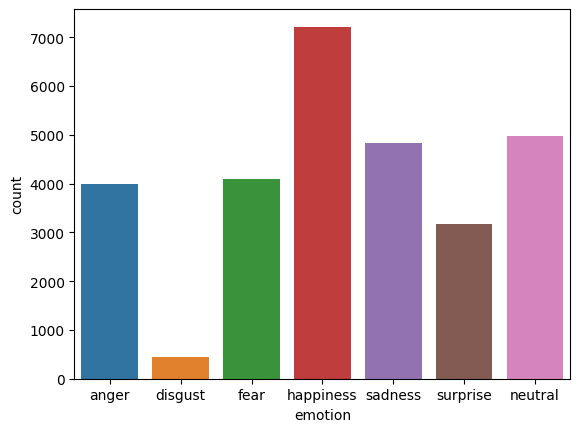

In [25]:
sns.countplot(x=y)
plt.xticks(range(7), emotion);

Text(0.5, 1.0, 'happiness')

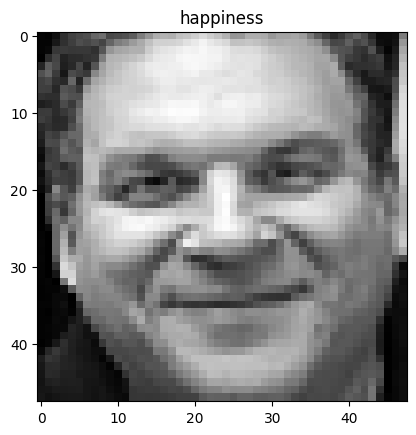

In [26]:
plt.imshow(X[14].reshape((48,48)), cmap='gray')
plt.title(emotion[y[14]])

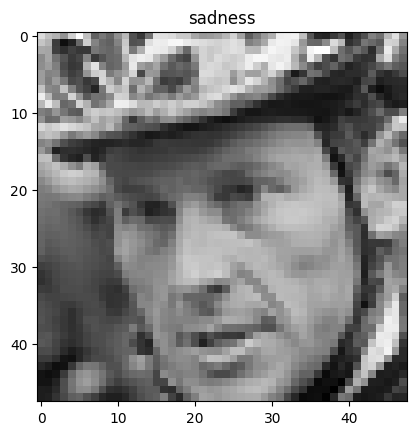

In [27]:
for i in range(1,20):
    plt.imshow(X[i].reshape((48,48)), cmap='gray')
    plt.title(emotion[y[i]])

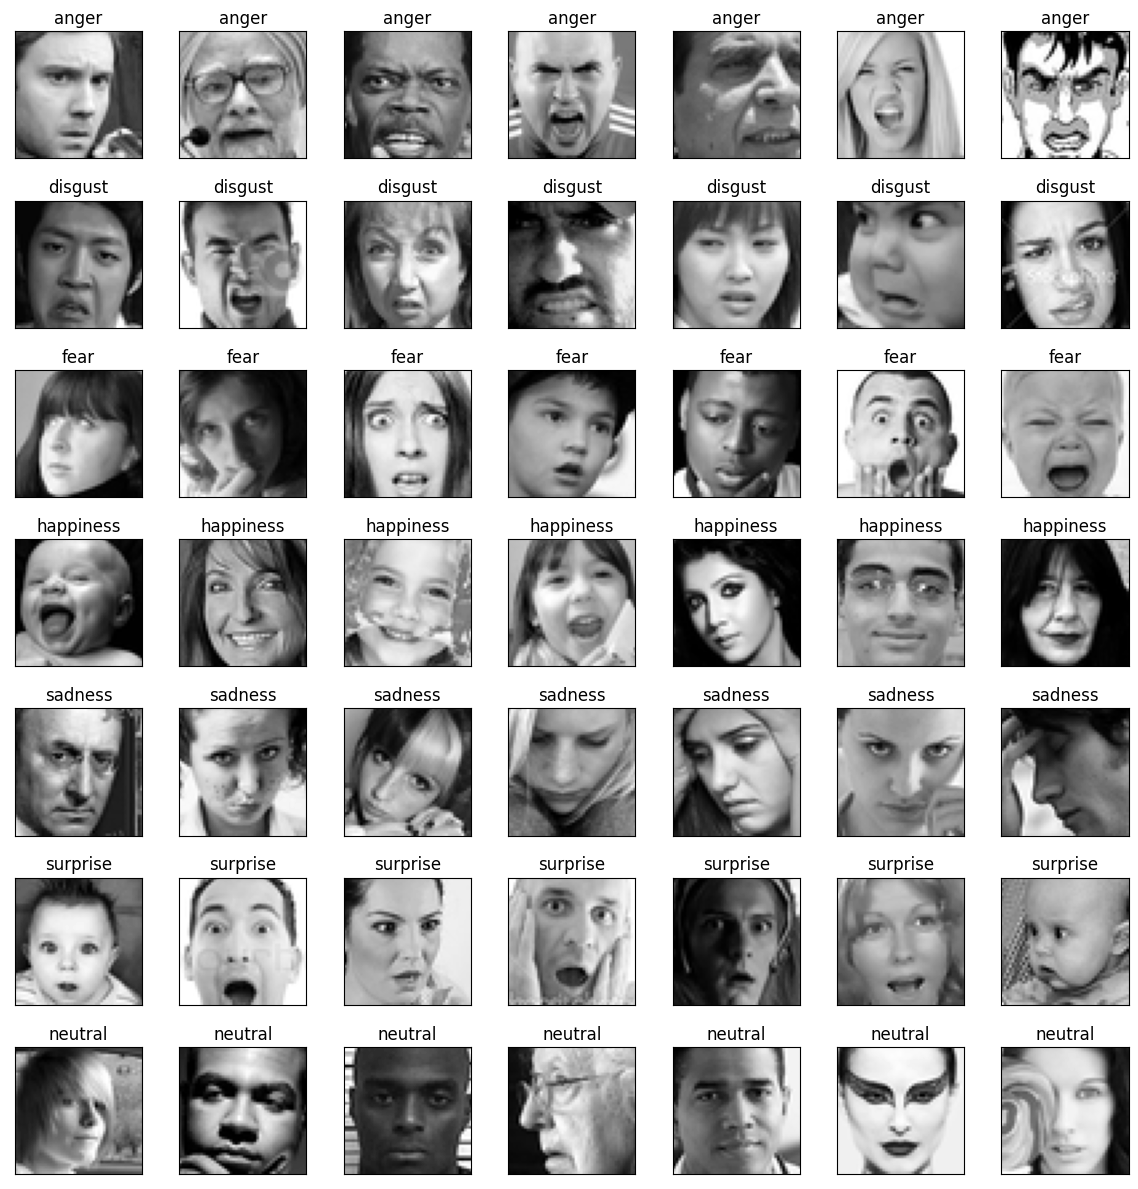

In [28]:
fig = plt.figure(1, (12,12))
k=0

for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion[label])
        plt.tight_layout()

In [29]:
le = LabelEncoder()
img_labels = le.fit_transform(y)
img_labels = to_categorical(img_labels)
img_labels.shape

(28709, 7)

In [30]:
X.shape,img_labels.shape

((28709, 48, 48, 1), (28709, 7))

In [31]:
X = X/255.

In [32]:
X

array([[[[0.27450982],
         [0.3137255 ],
         [0.32156864],
         ...,
         [0.20392157],
         [0.16862746],
         [0.16078432]],

        [[0.25490198],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862746],
         [0.21176471],
         ...,
         [0.19215687],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490198],
         [0.16470589],
         ...,
         [0.28235295],
         [0.21960784],
         [0.16862746]],

        [[0.3019608 ],
         [0.32156864],
         [0.30980393],
         ...,
         [0.4117647 ],
         [0.27450982],
         [0.18039216]],

        [[0.3019608 ],
         [0.28235295],
         [0.32941177],
         ...,
         [0.41568628],
         [0.42745098],
         [0.32156864]]],


       [[[0.5921569 ],
         [0.5882353 ],
         [0.57

In [33]:
model = Sequential()

model.add(Conv2D(filters = 64,kernel_size = (5, 5),input_shape = (48, 48, 1),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64,kernel_size = (5, 5),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


model.add(Flatten(name='flatten'))       
model.add(Dense(512,activation='relu',kernel_initializer='he_normal',))
model.add(BatchNormalization())   
model.add(Dropout(0.6))
model.add(Dense(7,activation='softmax'))

In [34]:
print(model)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

In [36]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [37]:
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [38]:
gen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True
)
gen.fit(X)

In [39]:
X

array([[[[0.27450982],
         [0.3137255 ],
         [0.32156864],
         ...,
         [0.20392157],
         [0.16862746],
         [0.16078432]],

        [[0.25490198],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862746],
         [0.21176471],
         ...,
         [0.19215687],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490198],
         [0.16470589],
         ...,
         [0.28235295],
         [0.21960784],
         [0.16862746]],

        [[0.3019608 ],
         [0.32156864],
         [0.30980393],
         ...,
         [0.4117647 ],
         [0.27450982],
         [0.18039216]],

        [[0.3019608 ],
         [0.28235295],
         [0.32941177],
         ...,
         [0.41568628],
         [0.42745098],
         [0.32156864]]],


       [[[0.5921569 ],
         [0.5882353 ],
         [0.57

In [40]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) 
lst_accu_stratified = []

In [41]:
img_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)